# The Mahalanobis Transformation

This notebook generates some of the figures used in the lectures for Week 3.

In [3]:
# Load the libraries we'll use
######################################

# Basic numerics
import math # for floor()
import numpy as np
import scipy as sp
import scipy.stats as st

# Suppress certain irrelevant warnings in the graphics libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cm # color maps
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

Make sure we have a directory in which to store figures.

In [5]:
# https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

## Construct a multivariate normal and draw some points from it

Begin by building the covariance matrix. 

In [8]:
# Construct a correaltion matrix
xCorr = 0.7
xCorMat = np.array(([1.0, xCorr], [xCorr, 1.0]))
xCorMat

array([[1. , 0.7],
       [0.7, 1. ]])

In [9]:
# Now scale the entries to get a covariance matrix
sigmaMat = np.diag( np.sqrt([1.0, 3.0]))
xCovMat = np.matmul( sigmaMat, np.matmul( xCorMat, sigmaMat ) )
xCovMat

array([[1.        , 1.21243557],
       [1.21243557, 3.        ]])

In [10]:
nPts = 400
xMean = np.array([5,4])

# Generate the points
# The recommended way to do this varies with the
# version of numpy
numpyVersionStr = np.__version__
versionStrParts = numpyVersionStr.split('.')

nVals = 1000
myAlpha = 2
myBeta = 4
if( int(versionStrParts[1]) >= 17 ):
    # Do the modern thing
    myPrng = np.random.default_rng()
    xVals = myPrng.multivariate_normal( xMean, xCovMat, size=nPts )
else:
    # Do the legacy thing
    xVals = np.random.multivariate_normal( xMean, xCovMat, size=nPts )

# Look at a few points to see that things have worked
xVals[0:5,:]

array([[4.19699306, 2.54244201],
       [4.8069351 , 0.96750331],
       [3.78819134, 3.6841409 ],
       [5.72068514, 6.11970256],
       [5.20906936, 3.3156929 ]])

## Do the Mahalanobis transform stepwise

First, centre the data, then rotate it so that it is uncorrelated and, finally, scale it. The computations here are closely related to those used in *Principal Components Analysis*, a topic that we'll cover in the first weeks of the 2nd semester.

In [13]:
# Centre the data
xSampleMean = np.mean( xVals, axis=0 )
print( xSampleMean ) 

yVals = np.zeros( (nPts, 2) )
for j in range(nPts):
    yVals[j,0] = xVals[j,0] - xSampleMean[0]
    yVals[j,1] = xVals[j,1] - xSampleMean[1]
    
yVals[0:5,:]

[4.95667629 3.84222536]


array([[-0.75968323, -1.29978335],
       [-0.14974119, -2.87472205],
       [-1.16848495, -0.15808447],
       [ 0.76400885,  2.2774772 ],
       [ 0.25239307, -0.52653247]])

In [14]:
# Rotate the data so the principal axes are parallel to the coordinate axes
yCovar = np.cov( yVals.T )
print( yCovar )

# Get eigenvectors and eigenvalues of the centred data's covariance matrix
eVals, eVects = np.linalg.eigh( yCovar )
print( eVals )
print( eVects )
np.linalg.norm( eVects, axis=0 ) # compute norm of columns: they should all be 1.

[[1.0042702  1.22390008]
 [1.22390008 2.97692345]]
[0.41872799 3.56246566]
[[-0.90207721  0.43157468]
 [ 0.43157468  0.90207721]]


array([1., 1.])

In [15]:
# Get the rotated variables, called u
uVals = yVals @ eVects
uVals[0:5,:]

array([[ 0.12433935, -1.50036499],
       [-1.10557912, -2.65784576],
       [ 0.9858384 , -0.64689291],
       [ 0.29370651,  2.38418716],
       [-0.45491612, -0.36604648]])

In [16]:
# Scale by the inverse eigenvalues
zVals = uVals @ np.linalg.inv( np.diag(np.sqrt(eVals)))

## Finally, plot those puppies

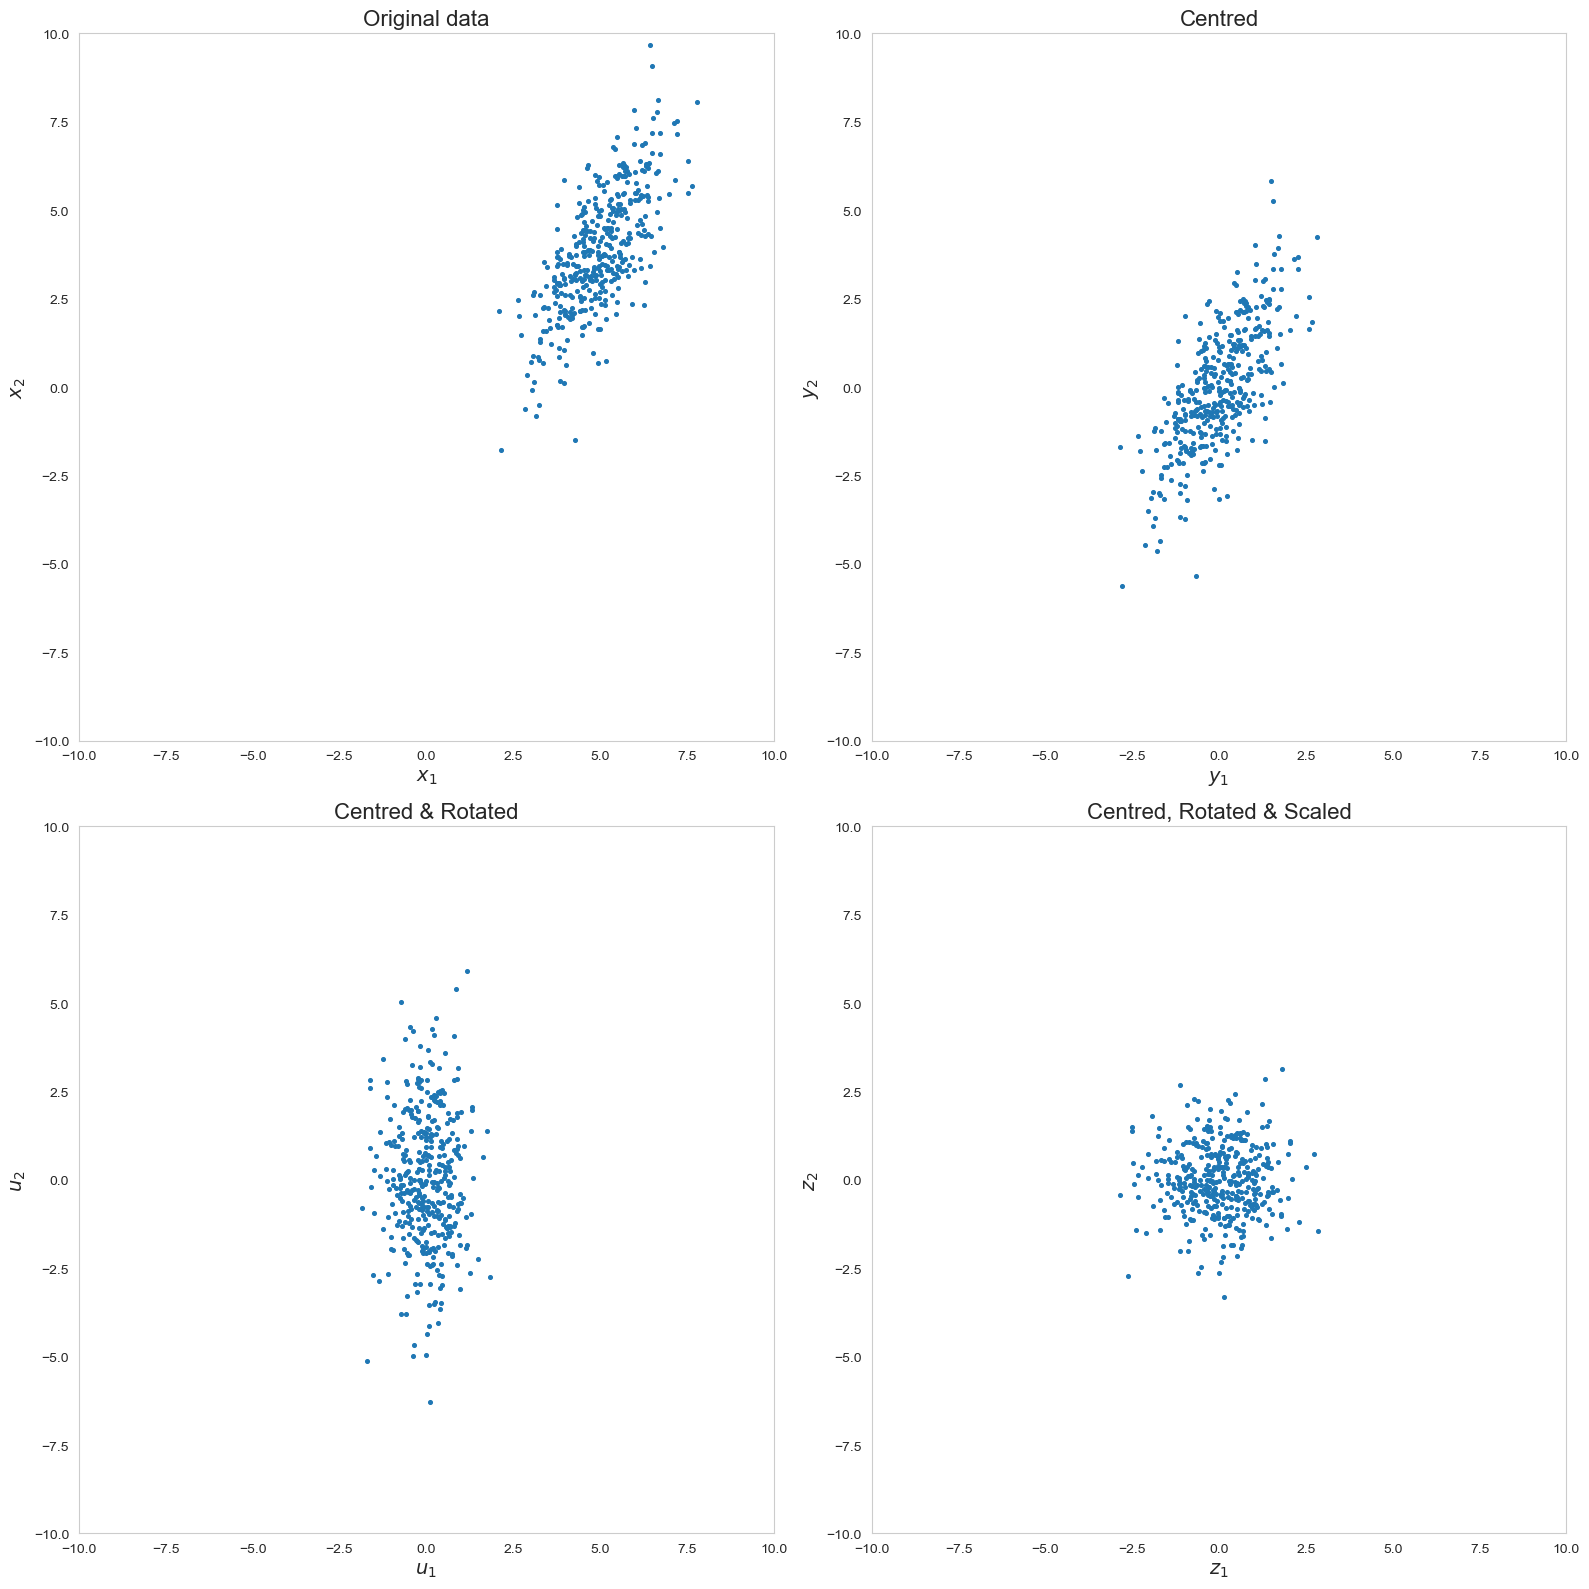

In [18]:
# Set the dimensions of the plot
widthInInches = 16
heightInInches = 16
myFig, myAxes = plt.subplots(2, 2, figsize=[widthInInches,heightInInches])

# Define a function to plot the points
def plotOnPanel( panelNum, points, title, xlab, ylab ):
    # Figure out the indices of thaxes we want
    row = math.floor( panelNum / 2 )
    col = panelNum % 2 
    
    # Set the limits of the plot
    xyLim = 10
    myAxes[row, col].set_xlim( (-xyLim, xyLim) )
    myAxes[row, col].set_ylim( (-xyLim, xyLim) )
    
    # Draw the points
    myAxes[row, col].scatter( points[:,0], points[:,1], s=7 )
    
    # Add the labels
    myAxes[row, col].set_xlabel( xlab, fontsize=14 )
    myAxes[row, col].set_ylabel( ylab, fontsize=14 )
    myAxes[row, col].set_title( title, fontsize=16 )

# Draw all four panels
plotOnPanel( 0, xVals, "Original data", r'$x_1$', r'$x_2$' )
plotOnPanel( 1, yVals, "Centred", r'$y_1$', r'$y_2$' )
plotOnPanel( 2, uVals, "Centred & Rotated", r'$u_1$', r'$u_2$' )
plotOnPanel( 3, zVals, "Centred, Rotated & Scaled", r'$z_1$', r'$z_2$' )
plt.tight_layout()

# Blap the image out, both to a file and to the screen
plt.savefig('Figures/MahalanobisDemo.pdf')
plt.show()

## Make a surface plot for a bivariate normal

Here we plot a surface that is also represented in the slides by a contour map.

In [21]:
# Set the parameters fo the distribution
vMean = np.array( [1,1] )
vCovar = np.array( ([1.0, 0.75], [0.75, 2.0]) )

# Generate the grid that we'll draw over
nSteps = 100
tmp = np.linspace( -4, 6, nSteps+1 )
v_grid = (tmp[0:nSteps] + tmp[1:(nSteps+1)]) / 2.0
V1, V2 = np.meshgrid(v_grid, v_grid)
V = np.dstack( (V1, V2) )

# Evaluate the density there
pdfVals = st.multivariate_normal.pdf( V, mean=vMean, cov=vCovar )

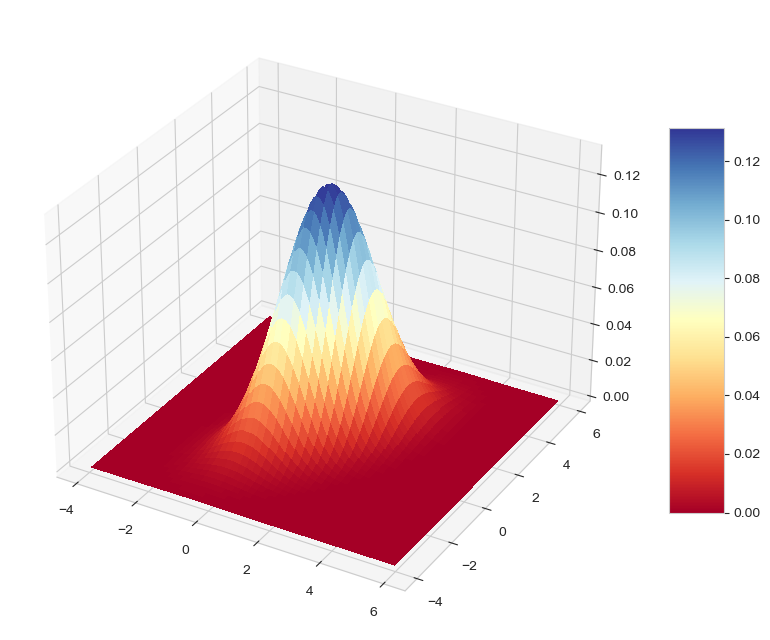

In [22]:
# This seems to be needed on older versions of matplotlib
from mpl_toolkits.mplot3d import Axes3D

# Set the dimensions of the plot
widthInInches = 10
heightInInches = 10
myFig = plt.figure( figsize=(widthInInches, heightInInches) )
myAx = plt.axes(projection='3d')

# Plot the surface.
surf = myAx.plot_surface(V1, V2, pdfVals, cmap=cm.RdYlBu,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
myFig.colorbar(surf, shrink=0.5, aspect=7)

# Blap the image out, both to a file and to the screen
plt.savefig('Figures/mvn3dDensity.pdf')
plt.show()